In [2]:
%matplotlib inline
import os
import pickle
import argparse
import numpy as np
from itertools import cycle
from collections import defaultdict
from functools import partial
from typing import List, Dict, Tuple

from qanta.guesser.abstract import AbstractGuesser
from qanta.datasets.quiz_bowl import QuestionDatabase
from qanta.util import constants as c
from qanta.buzzer import constants as bc
from qanta import logging
from qanta.buzzer.util import GUESSERS, load_protobowl
from qanta.reporting.report_generator import ReportGenerator
from qanta.util.multiprocess import _multiprocess

import matplotlib

/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/airsplay/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from qanta import logging
log = logging.get(__name__)
N_GUESSERS = len(GUESSERS)
MAXINT = 99999
HISTO_RATIOS = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# continuous valued statistics
EOP_STAT_KEYS_0 = [
        'buzz', # did the buzzer buzz
        'choose_best', # did the buzzer choose the best guesser (earliest correct)
        'choose_hopeful', # did the buzzer choose a hopeful guesser
        'rush', # did the buzzer rush (w.r.t to all guessers)
        'late', # did the buzzer buzz too late (w.r.t to all guessers)
        'not_buzzing_when_shouldnt', 
        'reward',
        'hopeful', # is the question hopeful (w.r.t to all guessers)
        'correct' # how many correct buzzers
        ]

# discrete valued statistics
EOP_STAT_KEYS_1 = [
        'choose_guesser', # the guesser chosen by the buzzer
        'best_guesser' # the best guesser
        ]

# overall guesser accuracy and buzzing frequency
HISTO_KEYS_0 = ['acc', 'buzz']

HISTO_KEYS_1 = [
        'buzz_correct',
        'wait_correct',
        'wait_wrong',
        'buzz_wrong',
        'wait_impossible',
        'buzz_impossible',
        'buzz_miss']

LINE_STYLES = {'acc': '-', 'buzz': '-'}
_STYLES = [':', '--', '-.']
for guesser, style in zip(GUESSERS, cycle(_STYLES)):
    LINE_STYLES['acc_{}'.format(guesser)] = style
    LINE_STYLES['buzz_{}'.format(guesser)] = style

In [4]:
def _get_top_guesses(qnum, question):
    top_guesses = [] # length * n_guessers
    # FIXME because there can be missing guessers, must iterate position first
    for _, position in question.groupby(['sentence', 'token']):
        top_guesses.append([])
        position = position.groupby('guesser')
        for guesser in GUESSERS:
            if guesser not in position.groups:
                top_guesses[-1].append(None)
            else:
                guesses = position.get_group(guesser).sort_values(
                        'score', ascending=False)
                top_guesses[-1].append(guesses.iloc[0].guess)
    # transpose top_guesses -> n_guessers * length
    return qnum, list(map(list, zip(*top_guesses)))

In [14]:
def _get_his_stats(buzzes: Dict[int, List[List[float]]],
              answers: Dict[int, str], qnum, top_guesses) \
            -> Tuple[int, Dict[str, List[int]]]:
    buzz = buzzes[qnum]
    answer = answers[qnum]

    # top_guesses: n_guessers * length
    length = len(top_guesses[0])
    if len(buzz) != length:
        raise ValueError("Length of buzzes {0} does not match with \
                guesses {1}".format(len(buzz), length))

    # n_guessers * length -> length * n_guessers
    top_guesses = list(map(list, zip(*top_guesses)))
    guesser_correct = [[int(x == answer) for x in g] for g in top_guesses]

    buzzer_correct = []
    for i, x in enumerate(buzz):
        x = np.argmax(x)
        if x < N_GUESSERS and guesser_correct[i][x]:
            buzzer_correct.append(1)
        else:
            buzzer_correct.append(0)

    stats = {k: [-1 for _ in HISTO_RATIOS] for k in HISTO_KEYS_0 + HISTO_KEYS_1}

    for i, r in enumerate(HISTO_RATIOS):
        pos = int(length * r)
        for j, g in enumerate(GUESSERS):
            cor = sum(x[j] for x in guesser_correct[:pos])
            buz = sum(np.argmax(x) == j for x in buzz[:pos])
            #stats['acc_{}'.format(g)][i] = int(cor > 0)
            #stats['buzz_{}'.format(g)][i] = int(buz > 0)
        cor_before = sum(sum(x) for x in guesser_correct[:pos])
        cor_after = sum(sum(x) for x in guesser_correct[pos:])
        buz = sum(np.argmax(x) < N_GUESSERS for x in buzz[:pos])
        buz_cor = sum(buzzer_correct[:pos])
        stats['acc'][i] = int(cor_before > 0)
        stats['buzz'][i] = int(buz > 0)
        stats['buzz_correct'][i] = int(buz_cor > 0)
        stats['wait_correct'][i] = int(buz == 0 and cor_before == 0 and cor_after > 0)
        stats['wait_impossible'][i] = int(buz == 0 and cor_before == 0 and cor_after == 0)
        stats['wait_wrong'][i] = int(buz == 0 and cor_before > 0)
        stats['buzz_wrong'][i] = int(buz > 0 and cor_before == 0 and cor_after > 0)
        stats['buzz_miss'][i] = int(buz > 0 and cor_before > 0 and buz_cor == 0)
        stats['buzz_impossible'][i] = int(buz > 0 and cor_before == 0 and cor_after == 0)
        ssum = stats['buzz_correct'][i] + stats['wait_correct'][i] + \
               stats['wait_wrong'][i] + stats['buzz_wrong'][i] + \
               stats['wait_impossible'][i] + stats['buzz_impossible'][i] +\
               stats['buzz_miss'][i]
        assert ssum == 1
    return qnum, stats

In [15]:
def get_his_stats(top_guesses, buzzes, answers, variables, fold, save_dir):
    log.info('[{}] Histogram reporting'.format(fold))

    inputs = top_guesses.items()
    worker = partial(_get_his_stats, buzzes, answers)
    his_stats = _multiprocess(worker, inputs, info='Histogram stats',
            multi=True)
    # qnum -> key -> list(int)
    his_stats = {k: v for k, v in his_stats}
    # key -> list(int)
    _his_stats = defaultdict(lambda: [[] for _ in HISTO_RATIOS])

    for stats in his_stats.values():
        for key in HISTO_KEYS_0 + HISTO_KEYS_1:
            for i, r in enumerate(HISTO_RATIOS):
                if stats[key][i] != -1:
                    _his_stats[key][i].append(stats[key][i])

    for key in HISTO_KEYS_0 + HISTO_KEYS_1:
        for i, r in enumerate(HISTO_RATIOS):
            s = _his_stats[key][i]
            _his_stats[key][i] = sum(s) / len(s) if len(s) > 0 else 0

    _his_stats = dict(_his_stats)
    
    his_output = ""
    for i, r in enumerate(HISTO_RATIOS):
        output = "{}:".format(r)
        for key in HISTO_KEYS_0 + HISTO_KEYS_1:
            output += "  {0} {1:.2f}".format(key, _his_stats[key][i])
        his_output += output + '\n'
        # print(output)

    ##### plot lines #####
    fig, ax = plt.subplots()
    lines = []
    for k in HISTO_KEYS_0:
        v = _his_stats[k]
        lines.append(plt.plot(HISTO_RATIOS, v, LINE_STYLES[k], label=k)[0])

    ax.set_xticks(HISTO_RATIOS)
    plt.legend(handles=lines)
    plt.title('{} histogram lines chart'.format(fold))
    if save_dir is not None:
        his_lines_dir = os.path.join(save_dir, 'his_{}_lines.pdf'.format(fold))
        plt.savefig(his_lines_dir, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

    ##### plot stacked area chart #####
    plt.plot([],[],color='c', alpha=0.5, label='buzz_correct')
    plt.plot([],[],color='y', alpha=0.5, label='buzz_miss')
    plt.plot([],[],color='r', alpha=0.5, label='buzz_wrong')
    plt.plot([],[],color='k', alpha=0.5, label='buzz_impossible')
    plt.plot([],[],color='m', alpha=0.5, label='wait_wrong')
    plt.plot([],[],color='g', alpha=0.5, label='wait_correct')
    plt.plot([],[],color='w', alpha=0.5, label='wait_impossible')

    plt.stackplot(list(range(len(HISTO_RATIOS))), 
            _his_stats['buzz_correct'], 
            _his_stats['buzz_miss'],
            _his_stats['buzz_wrong'], 
            _his_stats['buzz_impossible'],
            _his_stats['wait_wrong'], 
            _his_stats['wait_correct'], 
            _his_stats['wait_impossible'], 
            colors=['c', 'y', 'r', 'k', 'm', 'g', 'w'], alpha=0.5)
    plt.legend()
    plt.title('{} stacked area chart'.format(fold))
    if save_dir is not None:
        his_stacked_dir = os.path.join(save_dir, 'his_{}_stacked.pdf'.format(fold))
        plt.savefig(his_stacked_dir, bbox_inches='tight')
    plt.show()
    plt.close()

    if variables is not None:
        variables['his_stats'][fold] = _his_stats
        variables['his_lines'][fold] = his_lines_dir
        variables['his_stacked'][fold] = his_stacked_dir

    return _his_stats

In [6]:
BUZZES_DIR='output/buzzer/{0}_buzzes_{1}.pkl'
def get_protobowl(variables, protobowl_df, top_guesses_folds, folds, model_name, save_dir):
    questions = QuestionDatabase().all_questions()
    answers = {k: v.page for k, v in questions.items()}
    question_texts = {k: v.text for k, v in questions.items()}
    protobowl_ids = {k: questions[k].protobowl 
        for k in questions if questions[k].protobowl != ''}
    
    protobowl_keys = ['correct_before', 'correct_after', 
                 'rush_possible', 'rush_impossible', 
                 'late_possible', 'late_impossible',
                 'buzz_before_op', 'buzz_after_op', 'reward']

    for fold in folds:
        guesses_df = AbstractGuesser.load_guesses(
                bc.GUESSES_DIR, folds=[fold])
        guesses_df = guesses_df.groupby('qnum')
        buzzes_dir = BUZZES_DIR.format(fold, model_name)
        with open(buzzes_dir, 'rb') as f:
            buzzes = pickle.load(f)
            log.info('Loading buzzes from {}'.format(buzzes_dir))

        top_guesses = top_guesses_folds[fold]

        avg_stats = {k: [] for k in protobowl_keys}
        n_questions = 0
        for qnum, guess_list in top_guesses.items():
            if qnum not in protobowl_ids:
                continue
            protobowl_id = protobowl_ids[qnum]
            if protobowl_id not in protobowl_df.groups:
                continue
            n_questions += 1

            buzz = buzzes[qnum]
            answer = answers[qnum]

            # position in guesses -> real position
            position_mapping = []
            g_group = guesses_df.get_group(qnum)
            text = question_texts[qnum]
            g_group = g_group.groupby(['sentence', 'token']).groups
            _count = 0
            for sent in text:
                for word, x in enumerate(text[sent].split()):
                    if (sent, word) in g_group:
                        position_mapping.append(_count)
                    _count += 1
            position_mapping.append(_count)
            if len(position_mapping) != len(buzz):
                print(len(position_mapping), len(buzz))
                continue

            correct_position = len(buzz)
            buzzing_result = False
            for i in range(N_GUESSERS):
                for j in range(len(buzz)):
                    if guess_list[i][j] == answer:
                        if j < correct_position:
                            correct_position = j
                            break

            buzzing_position = len(buzz)
            for i in range(len(buzz)):
                choice = np.argmax(buzz[i])
                if choice < N_GUESSERS:
                    buzzing_position = position_mapping[i]
                    buzzing_result = (guess_list[choice][i] == answer)
                    break

            final_choice = np.argmax(buzz[-1][:N_GUESSERS])
            final_result = guess_list[final_choice][-1] == answer

            stats = {k: 0 for k in protobowl_keys}
            n_opponents = 0
            for opponent in protobowl_df.get_group(protobowl_id).itertuples():
                n_opponents += 1
                if opponent.position > buzzing_position:
                    stats['buzz_before_op'] += 1
                    if buzzing_result:
                        stats['reward'] += 10
                        stats['correct_before'] += 1
                    else:
                        stats['reward'] -= 5
                        if correct_position >= opponent.position and opponent.result == True:
                            stats['rush_impossible'] += 1
                        else:
                            stats['rush_possible'] += 1
                        if opponent.result == True:
                            stats['reward'] -= 10
                else:
                    stats['buzz_after_op'] += 1
                    if opponent.result == True:
                        stats['reward'] -= 10
                        if correct_position <= opponent.position:
                            stats['late_possible'] += 1
                        else:
                            stats['late_impossible'] += 1
                    else:
                        stats['reward'] += 5
                        if final_result:
                            stats['correct_after'] += 1
                            stats['reward'] += 10
            for k, v in dict(stats).items():
                avg_stats[k].append(v / n_opponents)
        for k, v in avg_stats.items():
            avg_stats[k] = sum(v) / n_questions

        # plotting
        plot_keys = protobowl_keys[:-1]
        plt.clf()
        ind = 0
        width = 0.5
        labels = []
        for k in plot_keys:
            if k not in avg_stats:
                continue
            plt.bar(ind, avg_stats[k], width)
            labels.append(k)
            ind += width * 2
        plt.xticks(list(range(len(labels))), labels, rotation=30)
        plt.subplots_adjust(bottom=0.3)
        plt.title('{} stats against Protobowl'.format(fold))
        if save_dir is not None:
            plot_dir = os.path.join(save_dir, '{}_protobowl.pdf'.format(fold))
            plt.savefig(plot_dir, bbox_inches='tight')
        else:
            plt.show()
        plt.clf() 

        if variables is not None:
            variables['protobowl_plot'][fold] = plot_dir
            variables['protobowl_stats'][fold] = avg_stats
        return avg_stats


In [7]:
all_questions = QuestionDatabase().all_questions()
answers = {k: v.page for k, v in all_questions.items()}

In [8]:
guesses_dfs = dict()
top_guesses = dict()
for fold in c.BUZZER_INPUT_FOLDS:
    guesses_dfs[fold] = AbstractGuesser.load_guesses(bc.GUESSES_DIR, folds=[fold])
    questions = guesses_dfs[fold].groupby('qnum')
    tg = _multiprocess(_get_top_guesses, questions, 
        info='Top guesses', multi=True)
    top_guesses[fold] = {k: v for k, v in tg}

[Top guesses] (16) done: 23211/23211
[Top guesses] (16) done: 7587/7587
[Top guesses] (16) done: 2089/2089
[Top guesses] (16) done: 1412/1412
[Top guesses] (16) done: 69/69


In [9]:
save_dir = 'output/summary/new_performance/'
import matplotlib.pyplot as plt

In [10]:
protobowl_df = load_protobowl().groupby('qid')

# Don't rerun above

# MLP without positional features

2017-05-25 18:22:24,232 - __main__ - INFO - [buzzerdev] Histogram reporting
[Histogram stats] (16) done: 7563/7587
/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


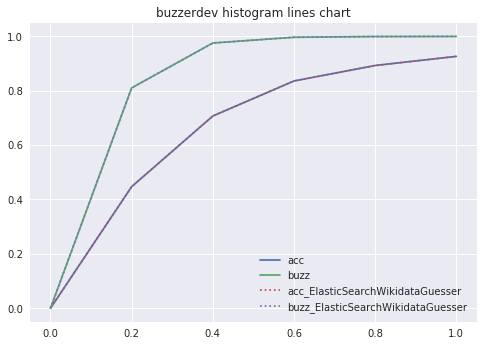

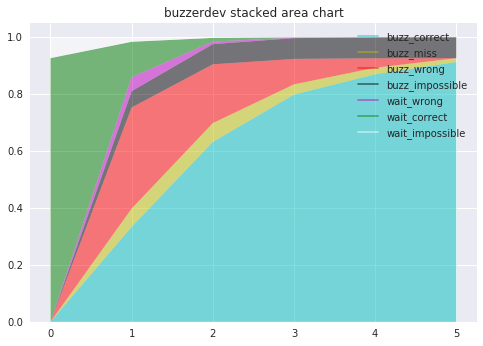

[0.0, 0.4469487280875181, 0.7067352049558455, 0.8356399103730064, 0.8924476077500989, 0.9260577303281929]


2017-05-25 18:22:58,740 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_mlp_nopos.pkl


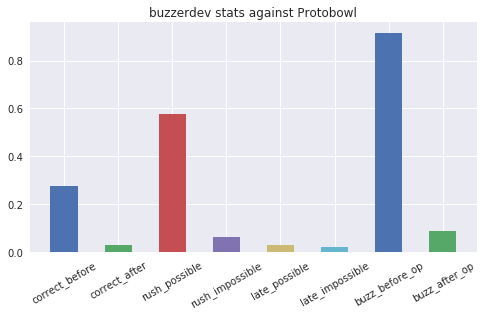

{'buzz_after_op': 0.08616497006835144,
 'buzz_before_op': 0.9138350299316549,
 'correct_after': 0.029107348261465476,
 'correct_before': 0.27483904982829704,
 'late_impossible': 0.021183155384739645,
 'late_possible': 0.03113157865283169,
 'reward': -4.257596350048772,
 'rush_impossible': 0.06371340433946644,
 'rush_possible': 0.5752825757638854}

In [74]:
BUZZES_DIR='output/buzzer/{0}_buzzes_{1}.pkl'
fold = 'buzzerdev'
buzzes_dir = BUZZES_DIR.format(fold, 'mlp_nopos')
with open(buzzes_dir, 'rb') as infile:
    nopos_buzzes = pickle.load(infile)

his_stats = get_his_stats(top_guesses[fold], nopos_buzzes, answers, None, fold, None)
print(his_stats['acc'])

get_protobowl(None, protobowl_df, top_guesses, [fold], 'mlp_nopos', None)

# MLP with positional features

2017-05-25 18:20:58,796 - __main__ - INFO - Loading buzzes from output/buzzer/buzzes_buzzerdev.pkl
2017-05-25 18:20:59,027 - __main__ - INFO - [buzzerdev] Histogram reporting
[Histogram stats] (16) done: 7564/7587
/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


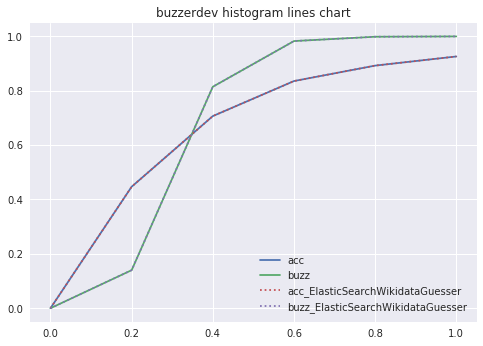

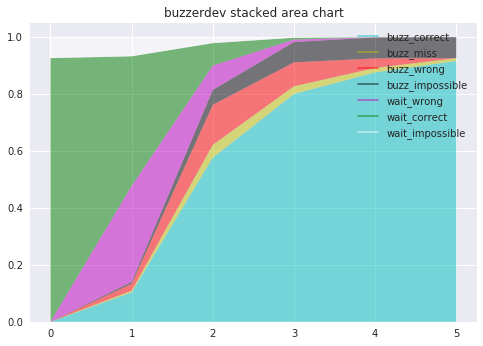

[0.0, 0.4469487280875181, 0.7067352049558455, 0.8356399103730064, 0.8924476077500989, 0.9260577303281929]


2017-05-25 18:21:26,089 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_mlp_pos.pkl


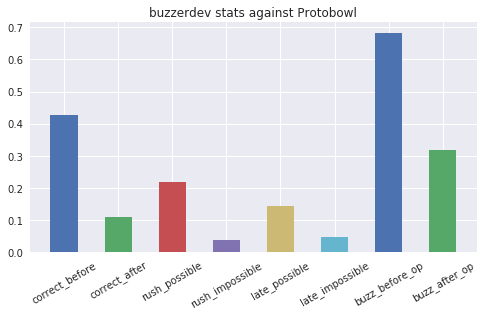

{'buzz_after_op': 0.31886036713245125,
 'buzz_before_op': 0.6811396328675529,
 'correct_after': 0.11032107909626176,
 'correct_before': 0.4267714893173902,
 'late_impossible': 0.04630876031806973,
 'late_possible': 0.14273210265001648,
 'reward': 1.367729396390283,
 'rush_impossible': 0.03710766070949027,
 'rush_possible': 0.21726048284066934}

In [73]:
BUZZES_DIR='output/buzzer/{0}_buzzes_{1}.pkl'
fold = 'buzzerdev'
buzzes_dir = bc.BUZZES_DIR.format(fold, 'mlp_pos')
with open(buzzes_dir, 'rb') as infile:
    log.info('Loading buzzes from {}'.format(buzzes_dir))
    pos_buzzes = pickle.load(infile)

his_stats = get_his_stats(top_guesses[fold], pos_buzzes, answers, None, fold, None)
print(his_stats['acc'])

get_protobowl(None, protobowl_df, top_guesses, [fold], 'mlp_pos', None)

# RNN with positional features

2017-05-25 18:36:55,921 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_pos.pkl
2017-05-25 18:36:59,492 - __main__ - INFO - [buzzerdev] Histogram reporting
[Histogram stats] (16) done: 7578/7587
/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


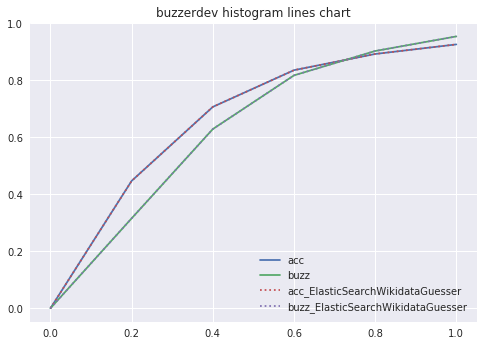

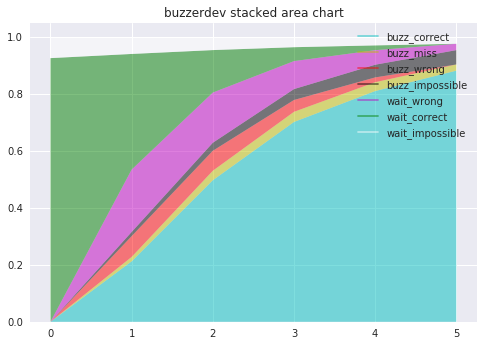

[0.0, 0.4469487280875181, 0.7067352049558455, 0.8356399103730064, 0.8924476077500989, 0.9260577303281929]


2017-05-25 18:37:31,050 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_pos.pkl


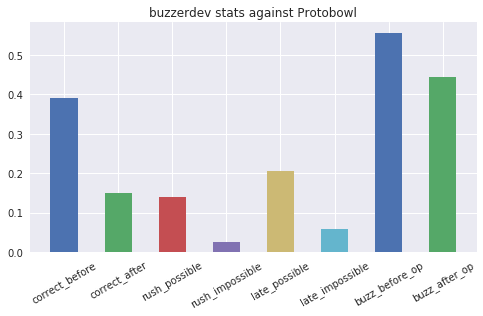

{'buzz_after_op': 0.4451691737543209,
 'buzz_before_op': 0.5548308262456807,
 'correct_after': 0.14871015833620427,
 'correct_before': 0.3917937657089729,
 'late_impossible': 0.05856348535710149,
 'late_possible': 0.20574012896354305,
 'reward': 1.8876922095348876,
 'rush_impossible': 0.024503497915335657,
 'rush_possible': 0.13853356262137048}

In [75]:
BUZZES_DIR='output/buzzer/{0}_buzzes_{1}.pkl'
fold = 'buzzerdev'
buzzes_dir = BUZZES_DIR.format(fold, 'rnn_pos')
with open(buzzes_dir, 'rb') as infile:
    log.info('Loading buzzes from {}'.format(buzzes_dir))
    rnn_buzzes = pickle.load(infile)

his_stats = get_his_stats(top_guesses[fold], rnn_buzzes, answers, None, fold, None)
print(his_stats['acc'])

get_protobowl(None, protobowl_df, top_guesses, [fold], 'rnn_pos', None)

# RNN without positional features

2017-05-25 18:53:58,822 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_nopos.pkl
2017-05-25 18:54:00,517 - __main__ - INFO - [buzzerdev] Histogram reporting
[Histogram stats] (16) done: 7587/7587
/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


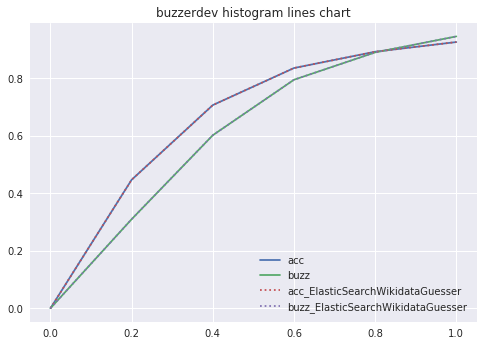

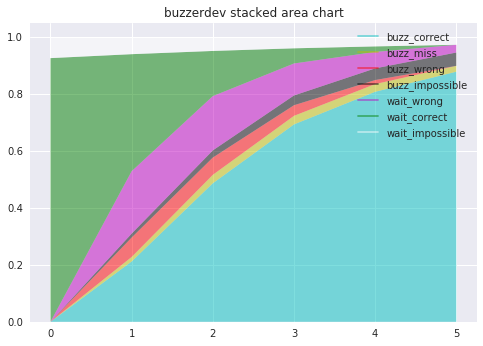

[0.0, 0.4469487280875181, 0.7067352049558455, 0.8356399103730064, 0.8924476077500989, 0.9260577303281929]


2017-05-25 18:54:27,045 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_nopos.pkl


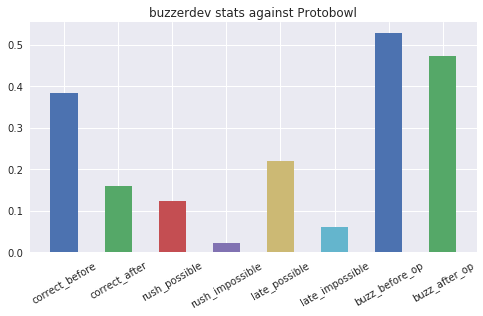

{'buzz_after_op': 0.4727539440025889,
 'buzz_before_op': 0.5272460559974117,
 'correct_after': 0.15843656247299578,
 'correct_before': 0.38230296427802923,
 'late_impossible': 0.061419622058223544,
 'late_possible': 0.21909721937801144,
 'reward': 1.9825964002184007,
 'rush_impossible': 0.0215257313902179,
 'rush_possible': 0.12341736032916321}

In [76]:
BUZZES_DIR='output/buzzer/{0}_buzzes_{1}.pkl'
fold = 'buzzerdev'
buzzes_dir = BUZZES_DIR.format(fold, 'rnn_nopos')
with open(buzzes_dir, 'rb') as infile:
    log.info('Loading buzzes from {}'.format(buzzes_dir))
    rnn_buzzes = pickle.load(infile)

his_stats = get_his_stats(top_guesses[fold], rnn_buzzes, answers, None, fold, None)
print(his_stats['acc'])

get_protobowl(None, protobowl_df, top_guesses, [fold], 'rnn_nopos', None)

# RNN 25

2017-05-25 19:15:34,848 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_nopos_25.pkl
2017-05-25 19:15:35,039 - __main__ - INFO - [buzzerdev] Histogram reporting
[Histogram stats] (16) done: 7577/7587
/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


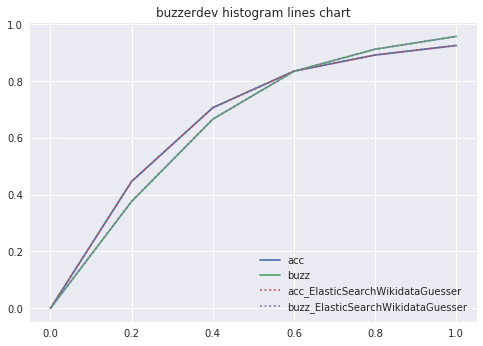

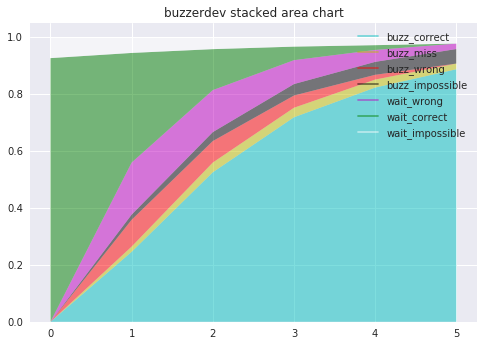

[0.0, 0.4469487280875181, 0.7067352049558455, 0.8356399103730064, 0.8924476077500989, 0.9260577303281929]


2017-05-25 19:16:05,043 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_nopos_25.pkl


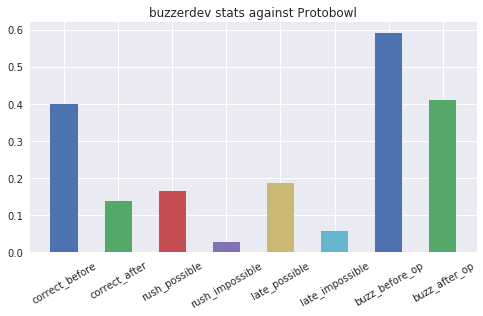

{'buzz_after_op': 0.4100197759098171,
 'buzz_before_op': 0.589980224090185,
 'correct_after': 0.13653476596905964,
 'correct_before': 0.399766248638618,
 'late_impossible': 0.056436380899771425,
 'late_possible': 0.1872186513076414,
 'reward': 1.6894590633379485,
 'rush_impossible': 0.026701690703696466,
 'rush_possible': 0.16351228474786952}

In [78]:
BUZZES_DIR='output/buzzer/{0}_buzzes_{1}.pkl'
fold = 'buzzerdev'
buzzes_dir = BUZZES_DIR.format(fold, 'rnn_nopos_25')
with open(buzzes_dir, 'rb') as infile:
    log.info('Loading buzzes from {}'.format(buzzes_dir))
    rnn_buzzes = pickle.load(infile)

his_stats = get_his_stats(top_guesses[fold], rnn_buzzes, answers, None, fold, None)
print(his_stats['acc'])

get_protobowl(None, protobowl_df, top_guesses, [fold], 'rnn_nopos_25', None)

2017-05-25 22:04:04,302 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_nopos_50.pkl
2017-05-25 22:04:05,196 - __main__ - INFO - [buzzerdev] Histogram reporting
[Histogram stats] (16) done: 7580/7587
/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


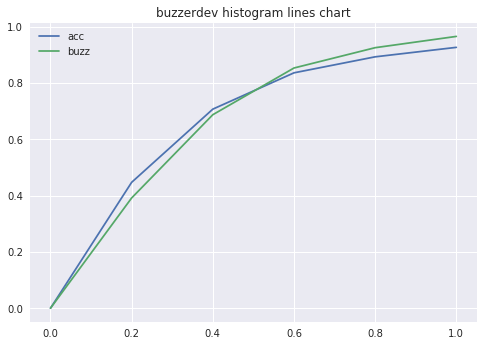

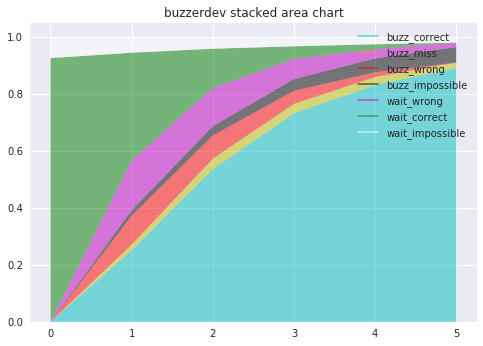

[0.0, 0.4469487280875181, 0.7067352049558455, 0.8356399103730064, 0.8924476077500989, 0.9260577303281929]


2017-05-25 22:04:37,722 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_nopos_50.pkl


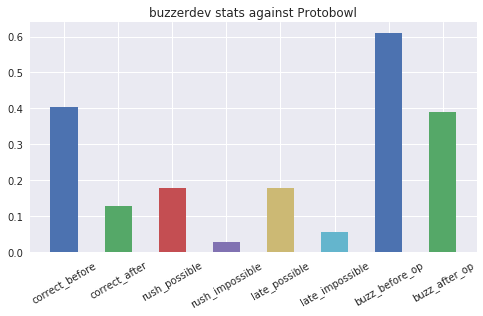

{'buzz_after_op': 0.3911820228985087,
 'buzz_before_op': 0.6088179771014931,
 'correct_after': 0.129291044453738,
 'correct_before': 0.40360203419775,
 'late_impossible': 0.05565047084958433,
 'late_possible': 0.17761683677485743,
 'reward': 1.558855295986374,
 'rush_impossible': 0.027616190112206784,
 'rush_possible': 0.17759975279153561}

In [16]:
BUZZES_DIR='output/buzzer/{0}_buzzes_{1}.pkl'
fold = 'buzzerdev'
buzzes_dir = BUZZES_DIR.format(fold, 'rnn_nopos_50')
with open(buzzes_dir, 'rb') as infile:
    log.info('Loading buzzes from {}'.format(buzzes_dir))
    rnn_buzzes = pickle.load(infile)

his_stats = get_his_stats(top_guesses[fold], rnn_buzzes, answers, None, fold, None)
print(his_stats['acc'])

get_protobowl(None, protobowl_df, top_guesses, [fold], 'rnn_nopos_50', None)

2017-05-25 22:05:35,637 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_nopos_100.pkl
2017-05-25 22:05:35,833 - __main__ - INFO - [buzzerdev] Histogram reporting
[Histogram stats] (16) done: 7581/7587
/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


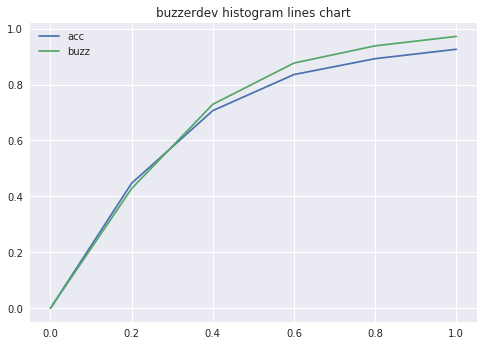

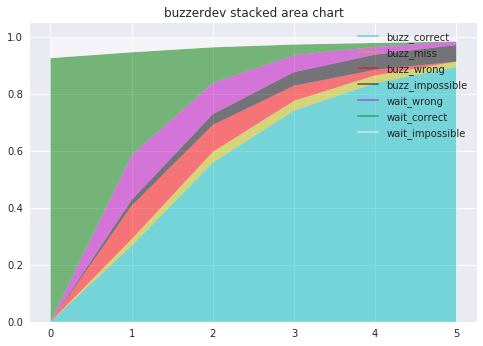

[0.0, 0.4469487280875181, 0.7067352049558455, 0.8356399103730064, 0.8924476077500989, 0.9260577303281929]


2017-05-25 22:06:06,486 - __main__ - INFO - Loading buzzes from output/buzzer/buzzerdev_buzzes_rnn_nopos_100.pkl


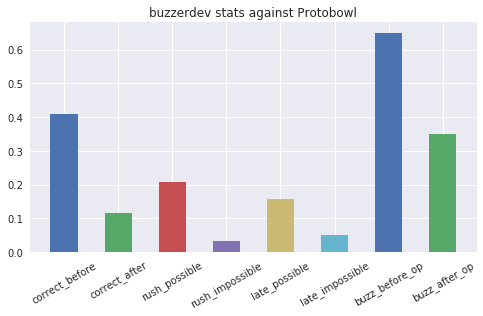

{'buzz_after_op': 0.35157457228064765,
 'buzz_before_op': 0.6484254277193553,
 'correct_after': 0.11674085910544693,
 'correct_before': 0.4095320944170597,
 'late_impossible': 0.05147867896098974,
 'late_possible': 0.157296919787029,
 'reward': 1.2879028791114222,
 'rush_impossible': 0.03188970938558382,
 'rush_possible': 0.20700362391671004}

In [17]:
BUZZES_DIR='output/buzzer/{0}_buzzes_{1}.pkl'
fold = 'buzzerdev'
buzzes_dir = BUZZES_DIR.format(fold, 'rnn_nopos_100')
with open(buzzes_dir, 'rb') as infile:
    log.info('Loading buzzes from {}'.format(buzzes_dir))
    rnn_buzzes = pickle.load(infile)

his_stats = get_his_stats(top_guesses[fold], rnn_buzzes, answers, None, fold, None)
print(his_stats['acc'])

get_protobowl(None, protobowl_df, top_guesses, [fold], 'rnn_nopos_100', None)

In [81]:
import sys
import time
import json
import pickle
import numpy as np
import codecs
import pandas as pd
import itertools
from functools import partial
from multiprocessing import Pool, Manager
from typing import List, Dict, Tuple, Optional

from qanta.util import constants as c
from qanta.util.io import safe_path
from qanta.config import conf
from qanta.datasets.quiz_bowl import QuestionDatabase
from qanta.guesser.abstract import AbstractGuesser
from qanta.buzzer.util import GUESSERS
from qanta.util.multiprocess import _multiprocess
from qanta import logging

N_GUESSERS = len(GUESSERS)
log = logging.get(__name__)

def _buzzer2vwexpo(buzzes: Dict[int, List[List[float]]], 
        qnum, question) -> Tuple[list, list, list, list]:
    '''Multiprocessing worker for buzzer2vwexpo
    buzzes: dictionary of qnum -> buzzing position
    inputs: qnum, question
        qnum: int, question id
        question: pd.group, the corresponding guesses
    return:
        buzzf: list of buzz file entries
        predf: list of vw pred file entries
        metaf: list of vw meta file entries
        finalf: list of final file entries
    '''
    qnum = int(qnum)
    try:
        buzz = buzzes[qnum]
    except KeyError:
        return None
    buzzf, predf, metaf, finalf = [], [], [], []
    final_guesses = [None for _ in GUESSERS]
    for i, (g_class, g_group) in enumerate(question.groupby('guesser')):
        # FIXME there might be missing guesses so the length might vary
        g_group = g_group.groupby(['sentence', 'token'])

        for pos, (sent_token, p_group) in enumerate(g_group):
            sent, token = sent_token
            p_group = p_group.sort_values('score', ascending=False)
            # normalize scores
            unnormalized_scores = list(p_group.score)
            _sum = sum(p_group.score)
            scores = [(r.score / _sum, r.guess) for r in p_group.itertuples()]
            final_guesses[i] = scores[0][1]
            for rank, (score, guess) in enumerate(scores):
                if np.argmax(buzz[pos]) == i and rank == 0:
                    buzzing = 1
                else:
                    buzzing = 0
                if isinstance(score, np.float):
                    score = score.tolist()
                # force negative weight for guesses that are not chosen
                weight = score if buzzing else score - 1
                predf.append([weight, qnum, sent, token])
                metaf.append([qnum, sent, token, guess])
                # manually do what csv.DictWriter does
                guess = guess if ',' not in guess else '"' + guess + '"'
                buzzer_score = buzz[pos][i]
                evidence = {g_class: {
                            'unnormalized_score': unnormalized_scores[rank], 
                            'buzzer_score': buzzer_score}}
                evidence = json.dumps(evidence)
                buzzf.append([qnum, sent, token, guess, evidence, buzzing, score])
    final_guess = final_guesses[np.argmax(buzz[-1][:N_GUESSERS])]
    final_guess = final_guess if ',' not in final_guess else '"' + final_guess + '"'
    finalf.append([qnum, final_guess])
    return buzzf, predf, metaf, finalf

def buzzer2vwexpo(guesses_df: pd.DataFrame, 
        buzzes: Dict[int, List[List[float]]], fold: str) -> None:
    '''Given buzzing positions, generate vw_pred, vw_meta, buzz and final files
    guesses_df: pd.DataFrame of guesses
    buzzes: dictionary of qnum -> buzzing position
    fold: string indicating the data fold
    '''
    inputs = guesses_df.groupby('qnum')
    worker = partial(_buzzer2vwexpo, buzzes)
    result = _multiprocess(worker, inputs, info='buzzer2vwexpo')
    result = [x for x in result if x is not None]
    buzzf, predf, metaf, finalf = list(map(list, zip(*result)))

    with codecs.open(safe_path(c.PRED_TARGET.format(fold)), 'w', 'utf-8') as pred_file, \
         codecs.open(safe_path(c.META_TARGET.format(fold)), 'w', 'utf-8') as meta_file, \
         codecs.open(safe_path(c.EXPO_BUZZ.format(fold)), 'w', 'utf-8') as buzz_file, \
         codecs.open(safe_path(c.EXPO_FINAL.format(fold)), 'w', 'utf-8') as final_file:

        buzz_file.write('question|sentence|word|page|evidence|final|weight\n')
        final_file.write('question,answer\n')
        
        log.info('\n\n[buzzer2vwexpo] writing to files')

        buzz_template = '|'.join(['{}' for _ in range(7)])
        buzz_out = '\n'.join(buzz_template.format(*r) for r in
                itertools.chain(*buzzf))
        buzz_file.write(buzz_out)
        log.info('buzz file written')

        final_out = '\n'.join('{0},{1}'.format(*r) for r in
                itertools.chain(*finalf))
        final_file.write(final_out)
        log.info('final file written')

        pred_out = '\n'.join('{0} {1}_{2}_{3}'.format(*r) for r in
                itertools.chain(*predf))
        pred_file.write(pred_out)
        log.info('vw_pred file written')

        meta_out = '\n'.join('{0} {1} {2} {3}'.format(*r) for r in
                itertools.chain(*metaf))
        meta_file.write(meta_out)
        log.info('vw_meta file written')

In [83]:
buzzes_dir = BUZZES_DIR.format('expo', 'rnn_nopos')
with open(buzzes_dir, 'rb') as infile:
    log.info('Loading buzzes from {}'.format(buzzes_dir))
    rnn_buzzes = pickle.load(infile)
guesses_df = AbstractGuesser.load_guesses(bc.GUESSES_DIR, folds=['expo'])
buzzer2vwexpo(guesses_df, rnn_buzzes, 'expo')

2017-05-25 19:20:13,483 - __main__ - INFO - Loading buzzes from output/buzzer/expo_buzzes_rnn_nopos.pkl
[buzzer2vwexpo] (16) done: 69/69
2017-05-25 19:20:18,175 - __main__ - INFO - 

[buzzer2vwexpo] writing to files
2017-05-25 19:20:18,325 - __main__ - INFO - buzz file written
2017-05-25 19:20:18,327 - __main__ - INFO - final file written


**********
69
**********


2017-05-25 19:20:18,442 - __main__ - INFO - vw_pred file written
2017-05-25 19:20:18,504 - __main__ - INFO - vw_meta file written
